# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


# Introduction

The goal of this analysis is to identify which recipes are most likely to achieve an 80% popularity rate while minimizing the recipes shown on the website that will not generate high traffic. This analysis will be divided into the following steps:

- Performing data validation by addressing missing values and incorrect column data types, as well as any outliers
- Creating visualiztions to support inditial EDA findings
- Using findings from the visualiztions and EDA, train suitable models to model the relationship between the variables
- Assess the performance of the models on a validation set of the data
- Align my results with the business metrics and provide answers to the business questions proposed

In [161]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Data Validation

This dataset has 947 rows, and 8 columns. All variables have been validated, and any changes to any columns can be seen below:

- `high_traffic`: This column contains 373 NaN values and a single unique non-null value. As the target variable, `high_traffic` is central to the analysis. The `high_traffic` value is marked as `High` if the recipe generated high traffic and `NaN` otherwise. Recognizing this as a binary classification problem, I encoded this column with `1` representing `'High'` and `0` representing `'Not High'`. It is assumed that `NaN` values indicate recipes that did not generate high traffic.

- `recipe`: This column has 947 unique values with no missing entries, confirmed to have no duplicates. As it serves as the primary key for the dataset, no cleaning was necessary.

- `calories`: There were 52 recipes with missing values, and while 47 potential outliers were identified, no significant outliers were confirmed. I observed that the 52 recipes with `NaN` values in `calories` also had `NaN` values in the `carbohydrate`, `sugar`, and `protein` columns. Instead of imputing these values, I decided to drop the rows to avoid introducing potential inaccuracies that could affect the model's performance. High and low calorie counts were retained as potential outliers due to their potential explanation by serving sizes and recipe categories, with the assumption that these values cannot be definitively classified as outliers without full recipe information.

- `carbohydrate`: This column had no missing values, but 58 potential outliers were identified, including 2 significant ones. The carbohydrate values of `530.42` and `383.06` were far above the mean of `35.07`, and even the next highest value of `265.09`, which impacted the mean slightly. Considering the `category` and `serving sizes`, these values may be able to be explained, but it is impossible to know for sure without knowing the full recipe. Given this information, and to not introduce bias into my data cleaning process, I will not remove these outliers.

- `sugar`: There were no missing values, and although 79 potential outliers were identified, none were deemed significant. The high `sugar` values observed were consistent with `serving sizes` and `categories`, showing no extreme anomalies. Therefore, no outliers were removed, as their validity could not be disputed without full recipe context.

- `protein`: Similar to the sugar column, there were no missing values and 82 potential outliers were identified. These high protein values, when compared to serving sizes, appeared reasonable, and no outliers were removed.

- `category`: The column had no missing values, but upon review, the presence of Chicken Breast alongside Chicken necessitated consolidation. According to the data definitions, Chicken Breast is not a valid category, and there should only be 10 categories, rather than the 11 identified. I merged Chicken Breast with Chicken and converted the column to a categorical data type.

- `servings`: This column contained no missing values but was incorrectly formatted as an object (string) rather than numeric, according to the data definitions. Additionally, the entries "4 as a snack" and "6 as a snack" were corrected to 4 and 6, respectively, to allow for proper conversion to numeric form. After conversion, the minimum and maximum values were confirmed to be correct, and no further cleaning was necessary. The data type of this column was left as `int` because while it acts more as a categorical column I will need to change it to `int` for model training later on.

In [162]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None
   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85

In [163]:
# Validate high_traffic
print(f"Num NA: {df['high_traffic'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['high_traffic'].isna().sum()}")
print(f"Num Unique: {df['high_traffic'].nunique()}")
print(f"Vals: {df['high_traffic'].unique()}")

# Impute NaN to 'Not High'
df['high_traffic'] = df['high_traffic'].fillna('0')
df['high_traffic'] = df['high_traffic'].replace({'High':'1'})
df['high_traffic'] = df['high_traffic'].astype('int')
print(df.head())

Num NA: 373
Num Non-NA: 574
Num Unique: 1
Vals: ['High' nan]
   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6            1
1       2     35.48         38.56  ...     Potato         4            1
2       3    914.28         42.68  ...  Breakfast         1            0
3       4     97.03         30.56  ...  Beverages         4            1
4       5     27.05          1.85  ...  Beverages         4            0

[5 rows x 8 columns]


In [164]:
# Validate recipe
print(f"Num NA: {df['recipe'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['recipe'].isna().sum()}")
print(f"Num Unique: {df['recipe'].nunique()}")

Num NA: 0
Num Non-NA: 947
Num Unique: 947


Num NA: 52
Num Non-NA: 895
Stats: count     895.000000
mean      435.939196
std       453.020997
min         0.140000
25%       110.430000
50%       288.550000
75%       597.650000
max      3633.160000
Name: calories, dtype: float64
Num NA: 0
Num Non-NA: 895
Stats: count     895.000000
mean      435.939196
std       453.020997
min         0.140000
25%       110.430000
50%       288.550000
75%       597.650000
max      3633.160000
Name: calories, dtype: float64


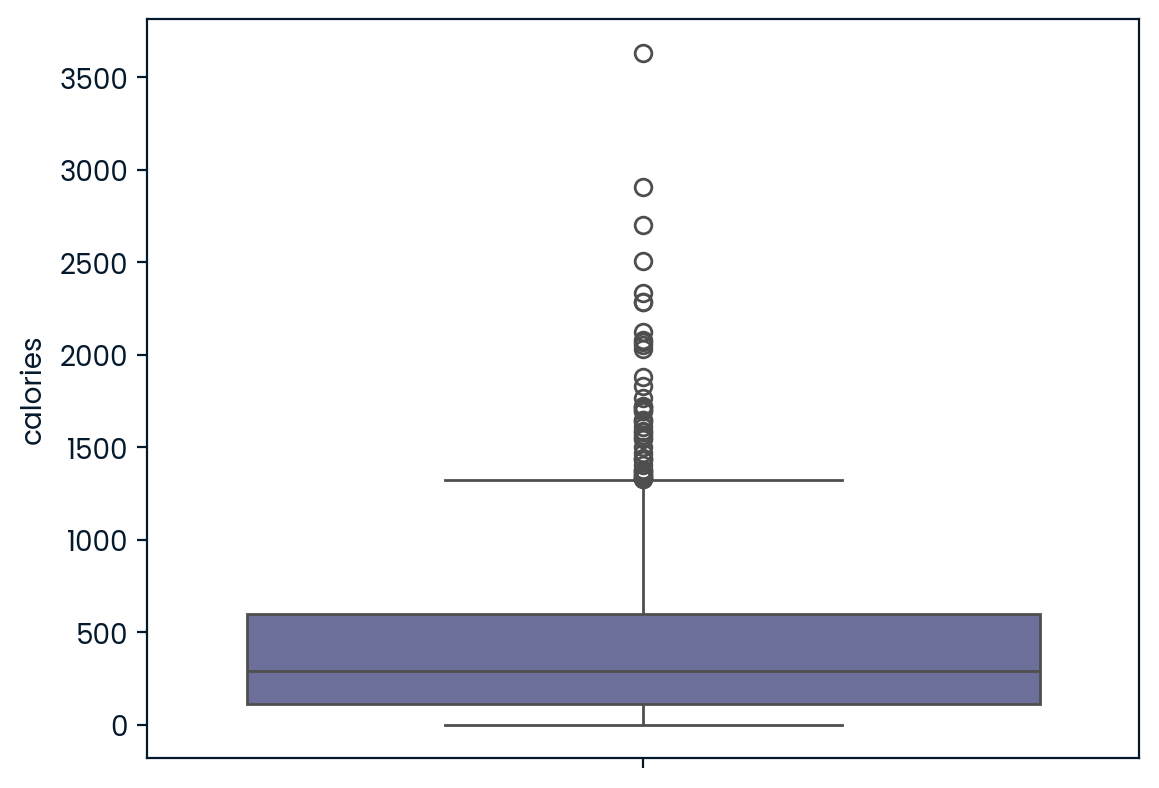

     recipe  calories  carbohydrate  ...        category      servings high_traffic
190     191   1330.30          1.63  ...            Meat             4            0
219     220   1330.48         10.34  ...  Chicken Breast             1            0
715     716   1335.54         27.82  ...       Breakfast             2            0
940     941   1337.50         49.91  ...         Chicken             4            0
355     356   1337.71          3.84  ...       Vegetable             6            1
694     695   1348.40        152.24  ...   One Dish Meal             2            1
823     824   1356.45          8.60  ...            Pork             2            1
381     382   1362.81         26.21  ...  Chicken Breast             4            0
805     806   1370.80          0.48  ...            Meat             4            0
546     547   1375.20         18.79  ...            Meat             2            0
752     753   1377.61         18.99  ...   One Dish Meal             4      

In [165]:
# Validate calories
print(f"Num NA: {df['calories'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['calories'].isna().sum()}")
print(f"Stats: {df['calories'].describe()}")

# Drop NaN rows
df = df.dropna(subset=['calories', 'carbohydrate', 'sugar', 'protein'], how='all')

# Reprint Statistics
print(f"Num NA: {df['calories'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['calories'].isna().sum()}")
print(f"Stats: {df['calories'].describe()}")

# Outliers
sns.boxplot(data=df['calories'])
plt.show()

calories_q1 = np.quantile(df['calories'], 0.25)
calories_q3 = np.quantile(df['calories'], 0.75)
calories_iqr = calories_q3 - calories_q1
print(df[(df['calories'] < calories_q1 - 1.5 * calories_iqr) | (df['calories'] > calories_q3 + 1.5 * calories_iqr)].sort_values('calories'))

Num NA: 0
Num Non-NA: 895
Stats: count    895.000000
mean      35.069676
std       43.949032
min        0.030000
25%        8.375000
50%       21.480000
75%       44.965000
max      530.420000
Name: carbohydrate, dtype: float64


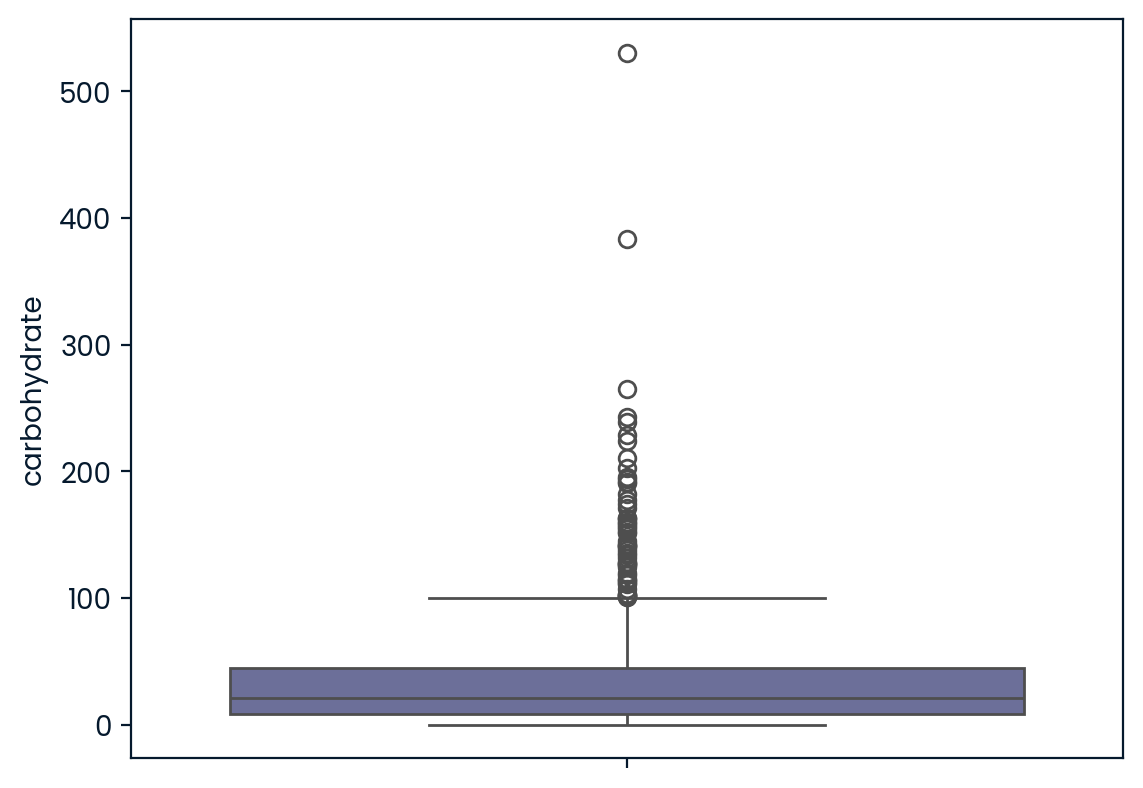

     recipe  calories  carbohydrate  ...       category  servings high_traffic
503     504    529.26        100.70  ...      Vegetable         4            1
428     429   1646.83        101.11  ...           Meat         1            1
159     160    777.37        101.73  ...        Dessert         4            1
798     799    100.82        102.44  ...         Potato         1            1
341     342     23.64        102.52  ...  One Dish Meal         4            1
677     678    988.66        102.72  ...      Breakfast         4            0
481     482    392.95        103.46  ...      Vegetable         6            1
691     692     56.91        107.12  ...      Vegetable         4            1
763     764    255.77        111.08  ...           Pork         1            1
243     244    653.90        111.80  ...         Potato         6            1
177     178    114.00        113.65  ...   Lunch/Snacks         4            0
584     585    373.30        113.99  ...  One Dish M

In [166]:
# Validate carbohydrate
print(f"Num NA: {df['carbohydrate'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['carbohydrate'].isna().sum()}")
print(f"Stats: {df['carbohydrate'].describe()}")

# Outliers
sns.boxplot(data=df['carbohydrate'])
plt.show()

carb_q1 = np.quantile(df['carbohydrate'], 0.25)
carb_q3 = np.quantile(df['carbohydrate'], 0.75)
carb_iqr = carb_q3 - carb_q1
print(df[(df['carbohydrate'] < carb_q1 - 1.5 * carb_iqr) | (df['carbohydrate'] > carb_q3 + 1.5 * carb_iqr)].sort_values('carbohydrate'))

Num NA: 0
Num Non-NA: 895
Stats: count    895.000000
mean       9.046547
std       14.679176
min        0.010000
25%        1.690000
50%        4.550000
75%        9.800000
max      148.750000
Name: sugar, dtype: float64


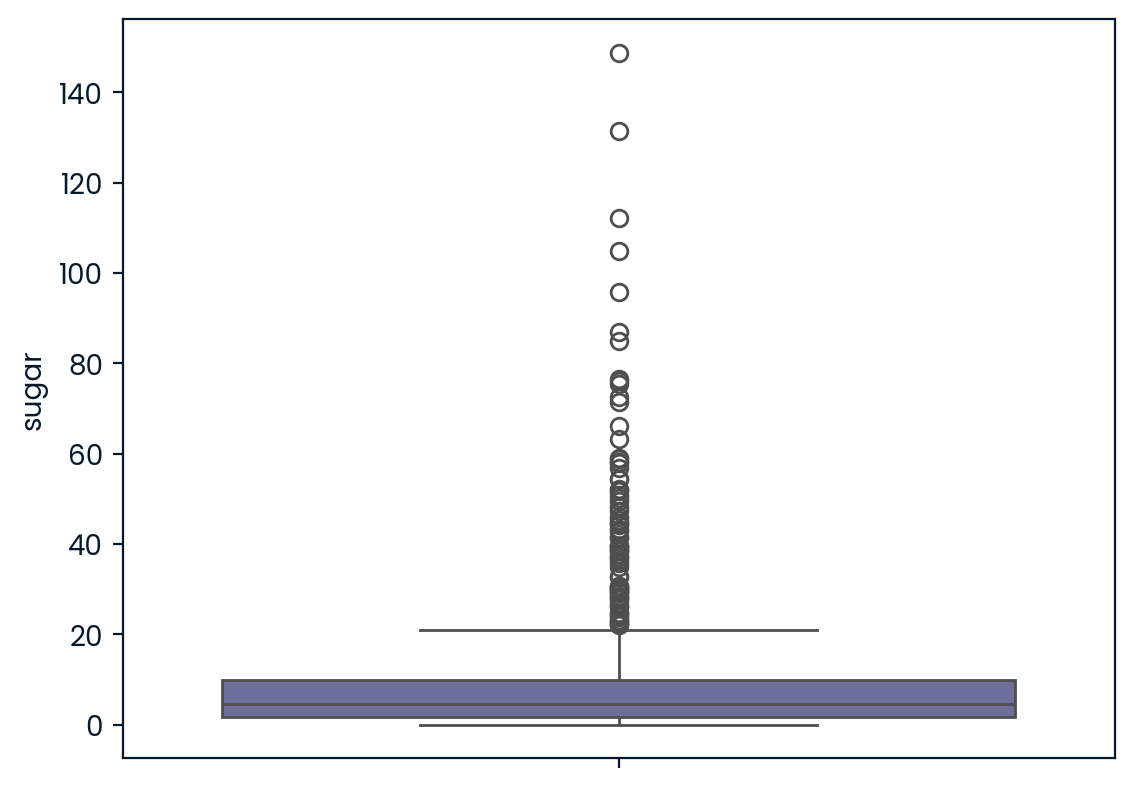

     calories   sugar      category servings
232    207.37   22.03     Beverages        4
266    436.03   22.30          Meat        4
942   1161.00   22.39  Lunch/Snacks        2
444    245.53   22.74       Chicken        6
113     76.77   22.95          Meat        2
..        ...     ...           ...      ...
737    686.84   95.75       Dessert        4
21      40.53  104.91       Dessert        4
575    128.30  112.24       Dessert        4
290    239.90  131.39       Dessert        2
540     60.62  148.75       Dessert        1

[79 rows x 4 columns]


In [167]:
# Validate sugar
print(f"Num NA: {df['sugar'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['sugar'].isna().sum()}")
print(f"Stats: {df['sugar'].describe()}")

# Outliers
sns.boxplot(data=df['sugar'])
plt.show()

sugar_q1 = np.quantile(df['sugar'], 0.25)
sugar_q3 = np.quantile(df['sugar'], 0.75)
sugar_iqr = sugar_q3 - sugar_q1
print(df[(df['sugar'] < sugar_q1 - 1.5 * sugar_iqr) | (df['sugar'] > sugar_q3 + 1.5 * sugar_iqr)].sort_values('sugar')[['calories', 'sugar', 'category', 'servings']])

Num NA: 0
Num Non-NA: 895
Stats: count    895.000000
mean      24.149296
std       36.369739
min        0.000000
25%        3.195000
50%       10.800000
75%       30.200000
max      363.360000
Name: protein, dtype: float64


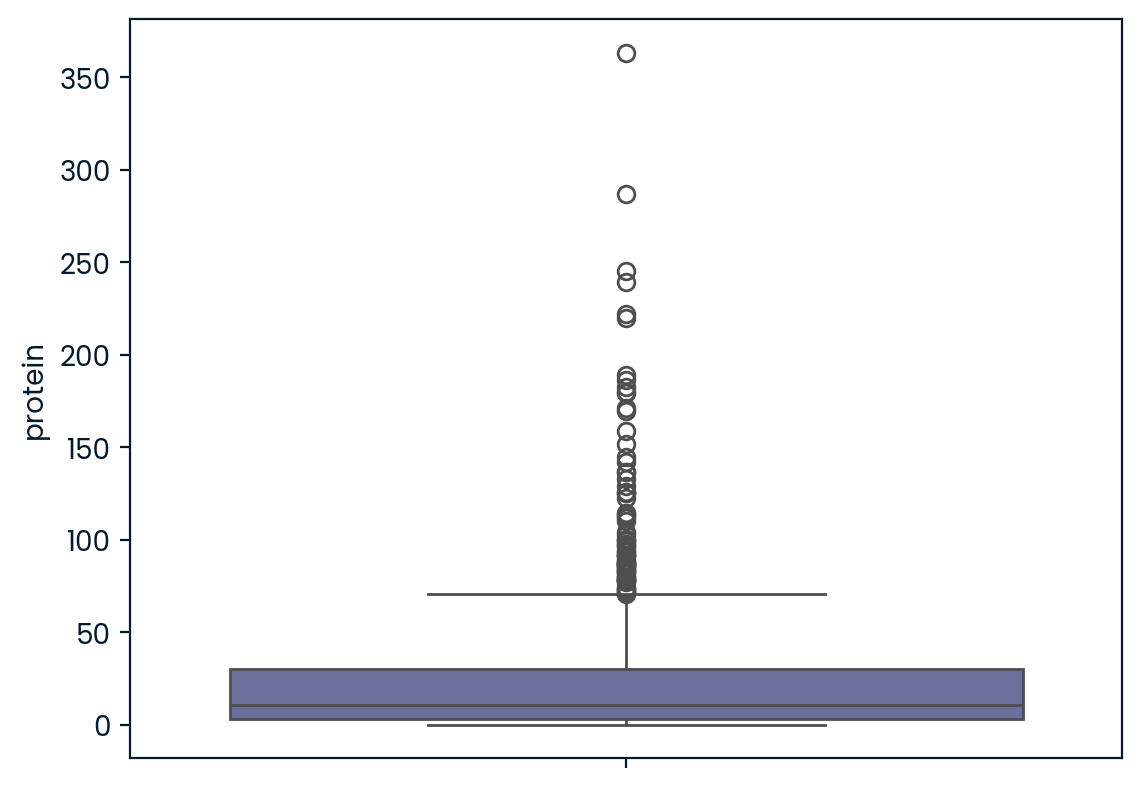

     calories  protein        category servings
358    231.20    70.75         Chicken        1
894    576.07    71.16            Pork        4
68    1105.15    71.51  Chicken Breast        1
162    935.77    71.88  Chicken Breast        2
52     367.30    73.35         Chicken        2
..        ...      ...             ...      ...
383    708.64   221.91  Chicken Breast        6
342    111.10   239.57    Lunch/Snacks        2
861   1646.67   245.57  Chicken Breast        6
695    891.11   286.97         Chicken        2
681    339.38   363.36  Chicken Breast        6

[77 rows x 4 columns]


In [168]:
# Validate protein
print(f"Num NA: {df['protein'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['protein'].isna().sum()}")
print(f"Stats: {df['protein'].describe()}")

# Outliers
sns.boxplot(data=df['protein'])
plt.show()

protein_q1 = np.quantile(df['protein'], 0.25)
protein_q3 = np.quantile(df['protein'], 0.75)
protein_iqr = protein_q3 - protein_q1
print(df[(df['protein'] < protein_q1 - 1.5 * protein_iqr) | (df['protein'] > protein_q3 + 1.5 * protein_iqr)].sort_values('protein')[['calories', 'protein', 'category', 'servings']])

In [169]:
# Validate category
print(f"Num NA: {df['category'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['category'].isna().sum()}")
print(f"Num Unique: {df['category'].nunique()}")
print(f"Unique: {df['category'].unique()}")

# Compare chicken breast and chicken categories
print(df[df['category'] == 'Chicken Breast'])
print(df[df['category'] == 'Chicken'])

# Merge chicken and chicken breast
df['category'] = df['category'].replace({'Chicken Breast':'Chicken'})
print(f"Unique: {df['category'].unique()}")

# Change to categorical dtype
df['category'] = pd.Categorical(df['category'])
print(df['category'])
print(df.dtypes)

Num NA: 0
Num Non-NA: 895
Num Unique: 11
Unique: ['Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Pork' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
     recipe  calories  carbohydrate  ...        category  servings high_traffic
6         7    183.94         47.95  ...  Chicken Breast         4            0
32       33    347.06          9.50  ...  Chicken Breast         4            0
38       39    264.62          1.50  ...  Chicken Breast         4            0
40       41    621.54         14.16  ...  Chicken Breast         6            1
43       44    262.12         17.46  ...  Chicken Breast         4            0
..      ...       ...           ...  ...             ...       ...          ...
905     906     42.30         12.14  ...  Chicken Breast         2            0
913     914   1089.14          5.14  ...  Chicken Breast         6            0
933     934     47.74          5.33  ...  Chicken Breast         4            1
939     940   2283.29

In [170]:
# Validate servings
print(f"Num NA: {df['servings'].isna().sum()}")
print(f"Num Non-NA: {len(df) - df['servings'].isna().sum()}")
print(f"Num Unique: {df['servings'].nunique()}")
print(f"Unique: {df['servings'].unique()}")

# Replace 4 and 6 as a snack with 4 and 6
df['servings'] = df['servings'].replace({'4 as a snack':'4', '6 as a snack':'6'})

# Change to numeric dtype
df['servings'] = df['servings'].astype('int')

# Print summary/confirm dtype
print(df['servings'].dtype)
print(f"Stats: {df['servings'].describe()}")

Num NA: 0
Num Non-NA: 895
Num Unique: 6
Unique: ['4' '1' '2' '6' '4 as a snack' '6 as a snack']
int64
Stats: count    895.000000
mean       3.458101
std        1.735979
min        1.000000
25%        2.000000
50%        4.000000
75%        4.000000
max        6.000000
Name: servings, dtype: float64


In [171]:
# Review data validation
print(df.describe()[['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'high_traffic']])
print(df.info())

          calories  carbohydrate  ...    servings  high_traffic
count   895.000000    895.000000  ...  895.000000    895.000000
mean    435.939196     35.069676  ...    3.458101      0.597765
std     453.020997     43.949032  ...    1.735979      0.490623
min       0.140000      0.030000  ...    1.000000      0.000000
25%     110.430000      8.375000  ...    2.000000      0.000000
50%     288.550000     21.480000  ...    4.000000      1.000000
75%     597.650000     44.965000  ...    4.000000      1.000000
max    3633.160000    530.420000  ...    6.000000      1.000000

[8 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null   

# Exploratory Analysis

I have investigated the target variable (`high_traffic`) and features of the recipes, as well as the relation between these. After analysis, I decided to apply the following changes to enable modeling:

- `calories`, `carbohydrate`, `sugar`, `protein`: Use a log transformation

I made an attempt at engineering features to see if I could pull out any significant relationships between multiple variables and `high_traffic` (including calories per serving and ratios between nutrient variables) but did not find any of significance.

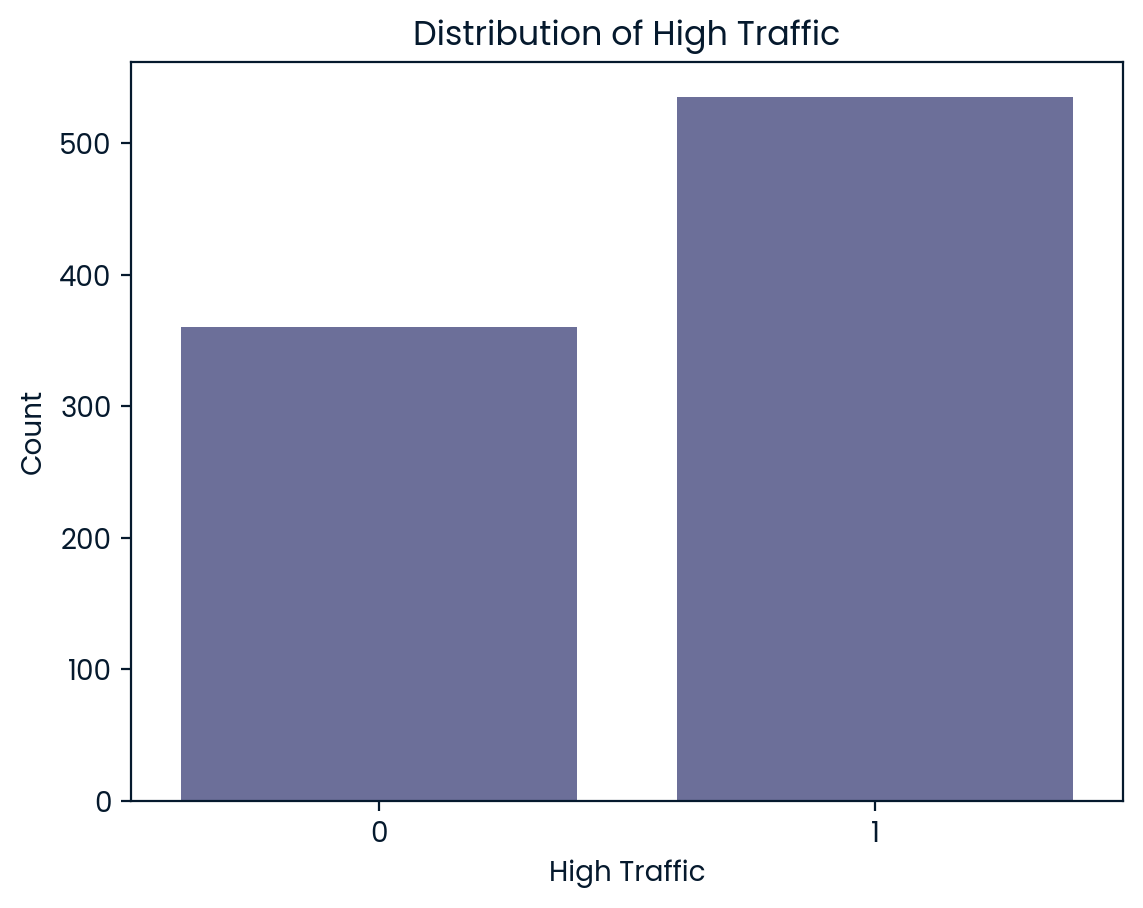

In [172]:
# Investage target variable
sns.countplot(data=df, x='high_traffic')
plt.title('Distribution of High Traffic')
plt.xlabel('High Traffic')
plt.ylabel('Count')
plt.show()

The histograms below show that the `calories`, `carbohydrate`, `sugar`, and `protein` columns are all skewed right. Therefore, a log transformation of these columns is appropriate to normalize the data, or get it close to a normal distribution. This is evident in the 4 plots below these.

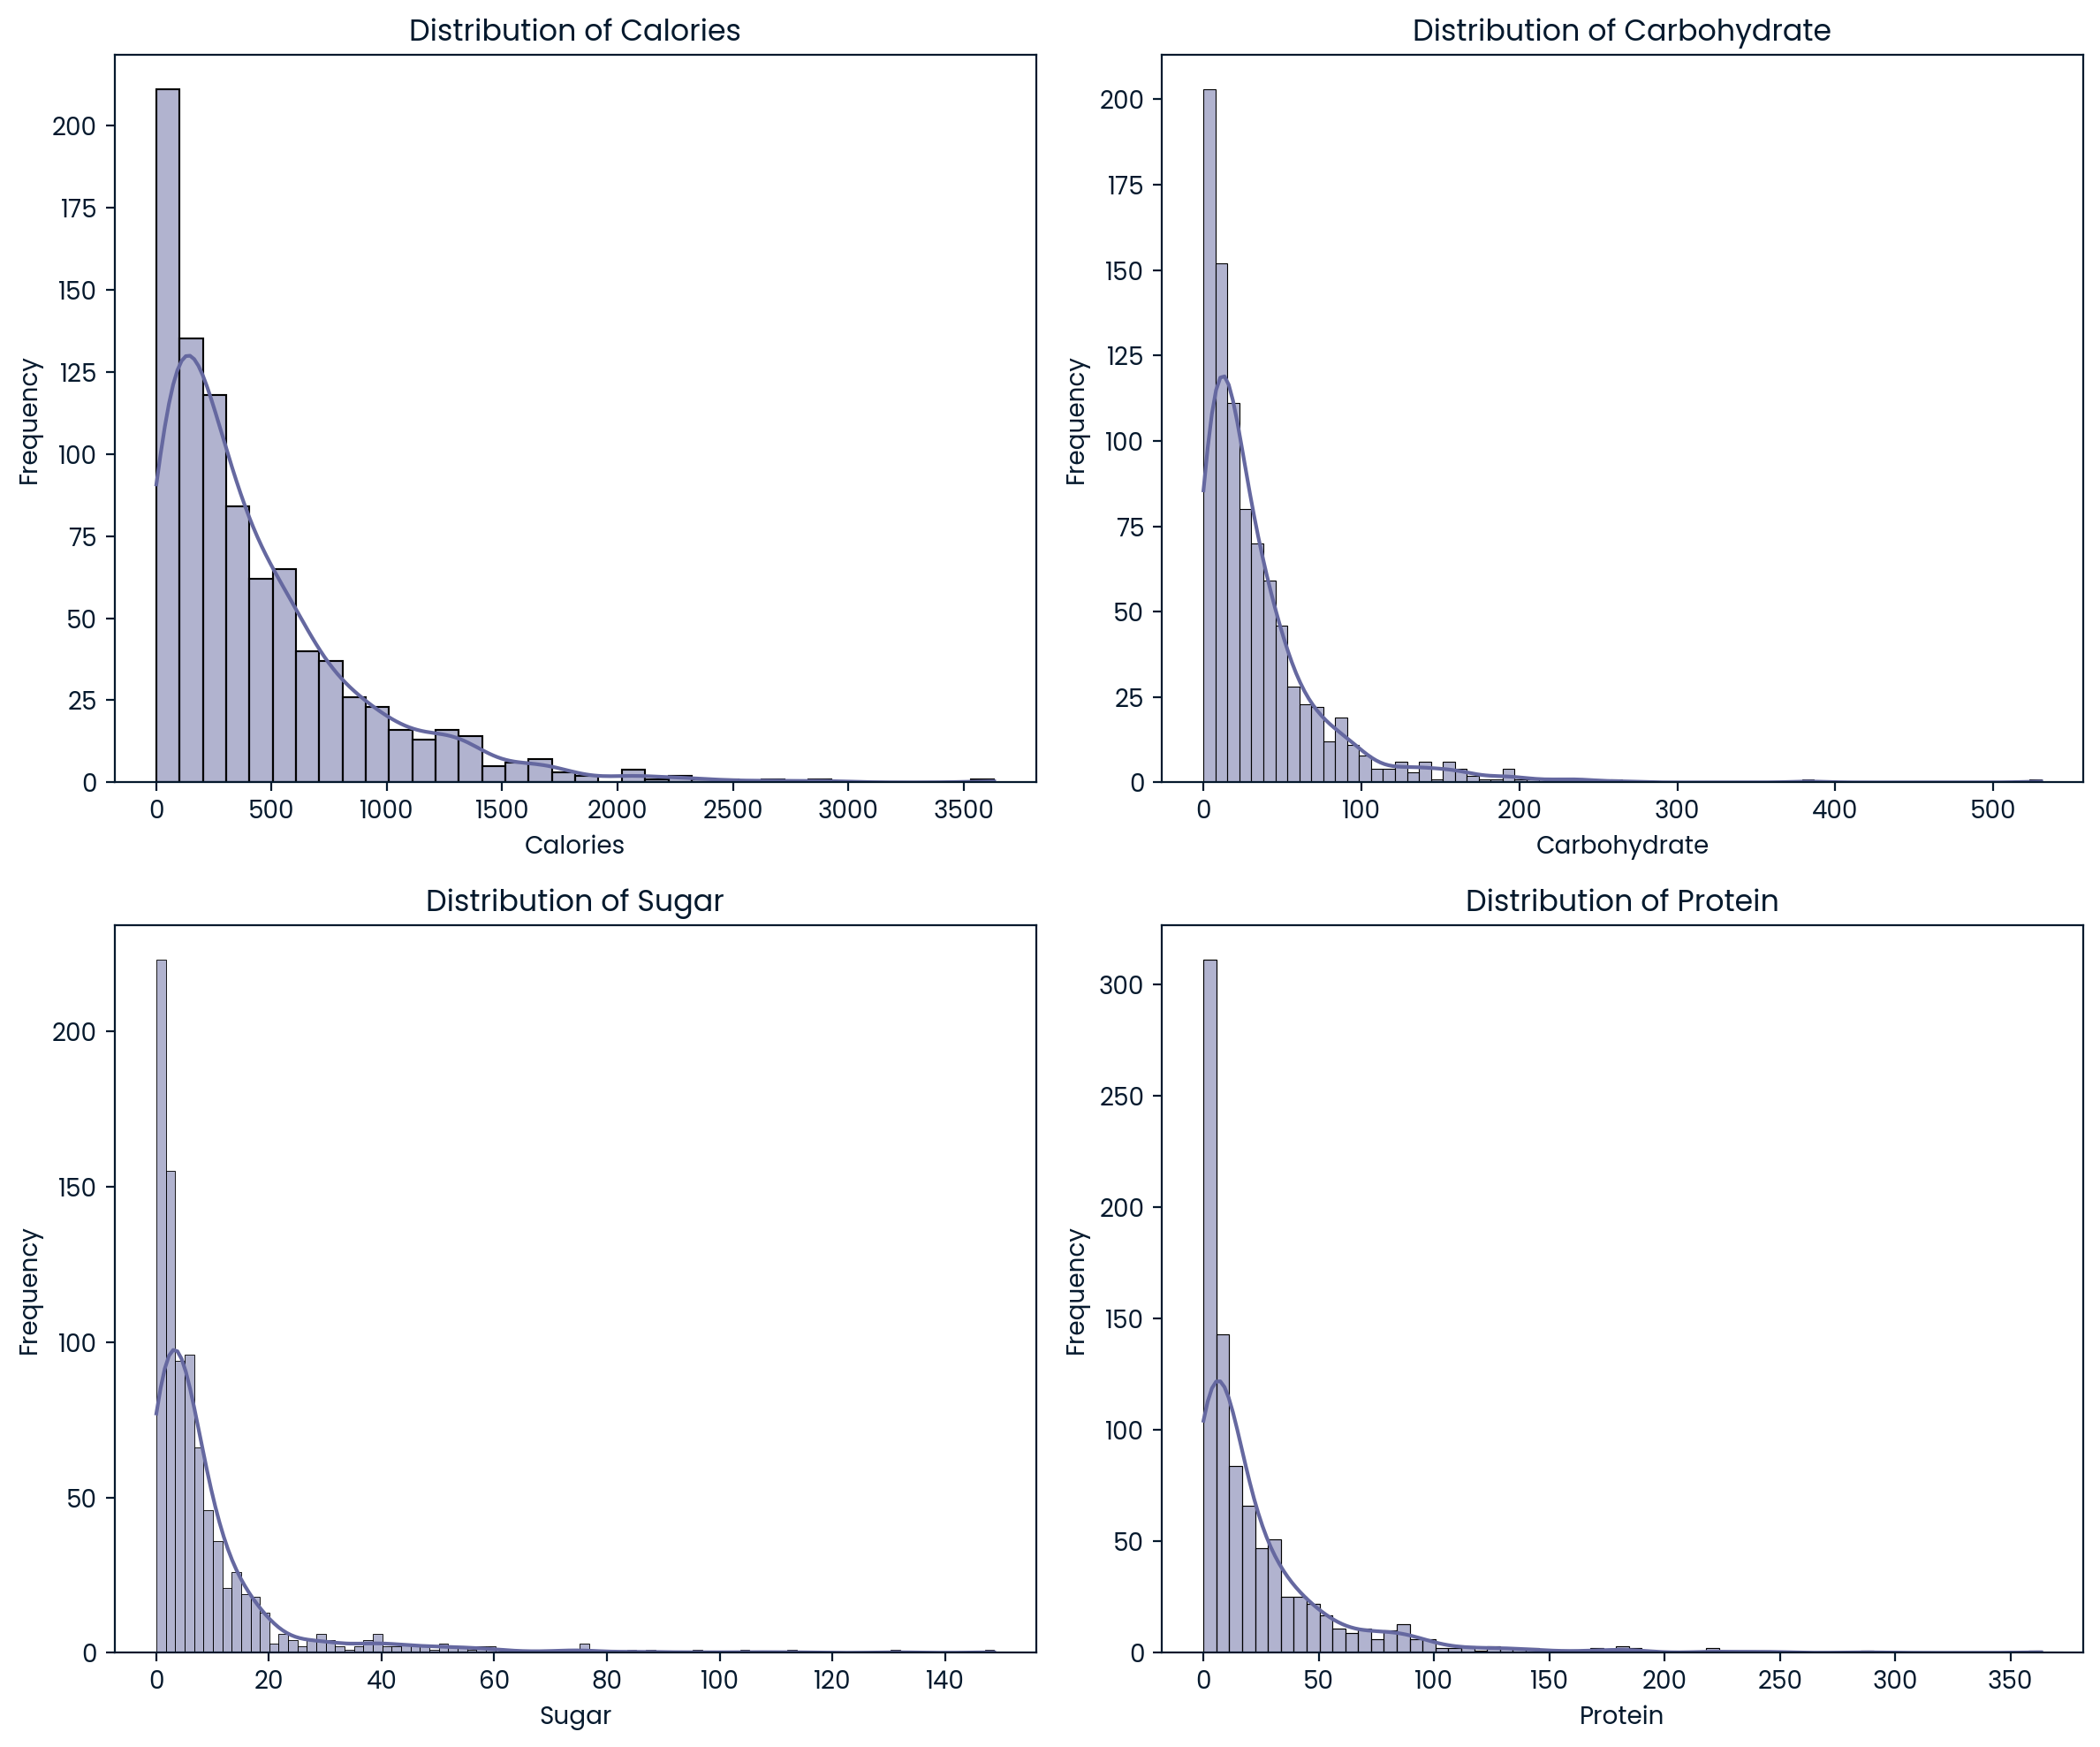

In [173]:
# Numeric cols histograms
hist_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

plt.figure(figsize=(12, 10))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df[col], kde=True)
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

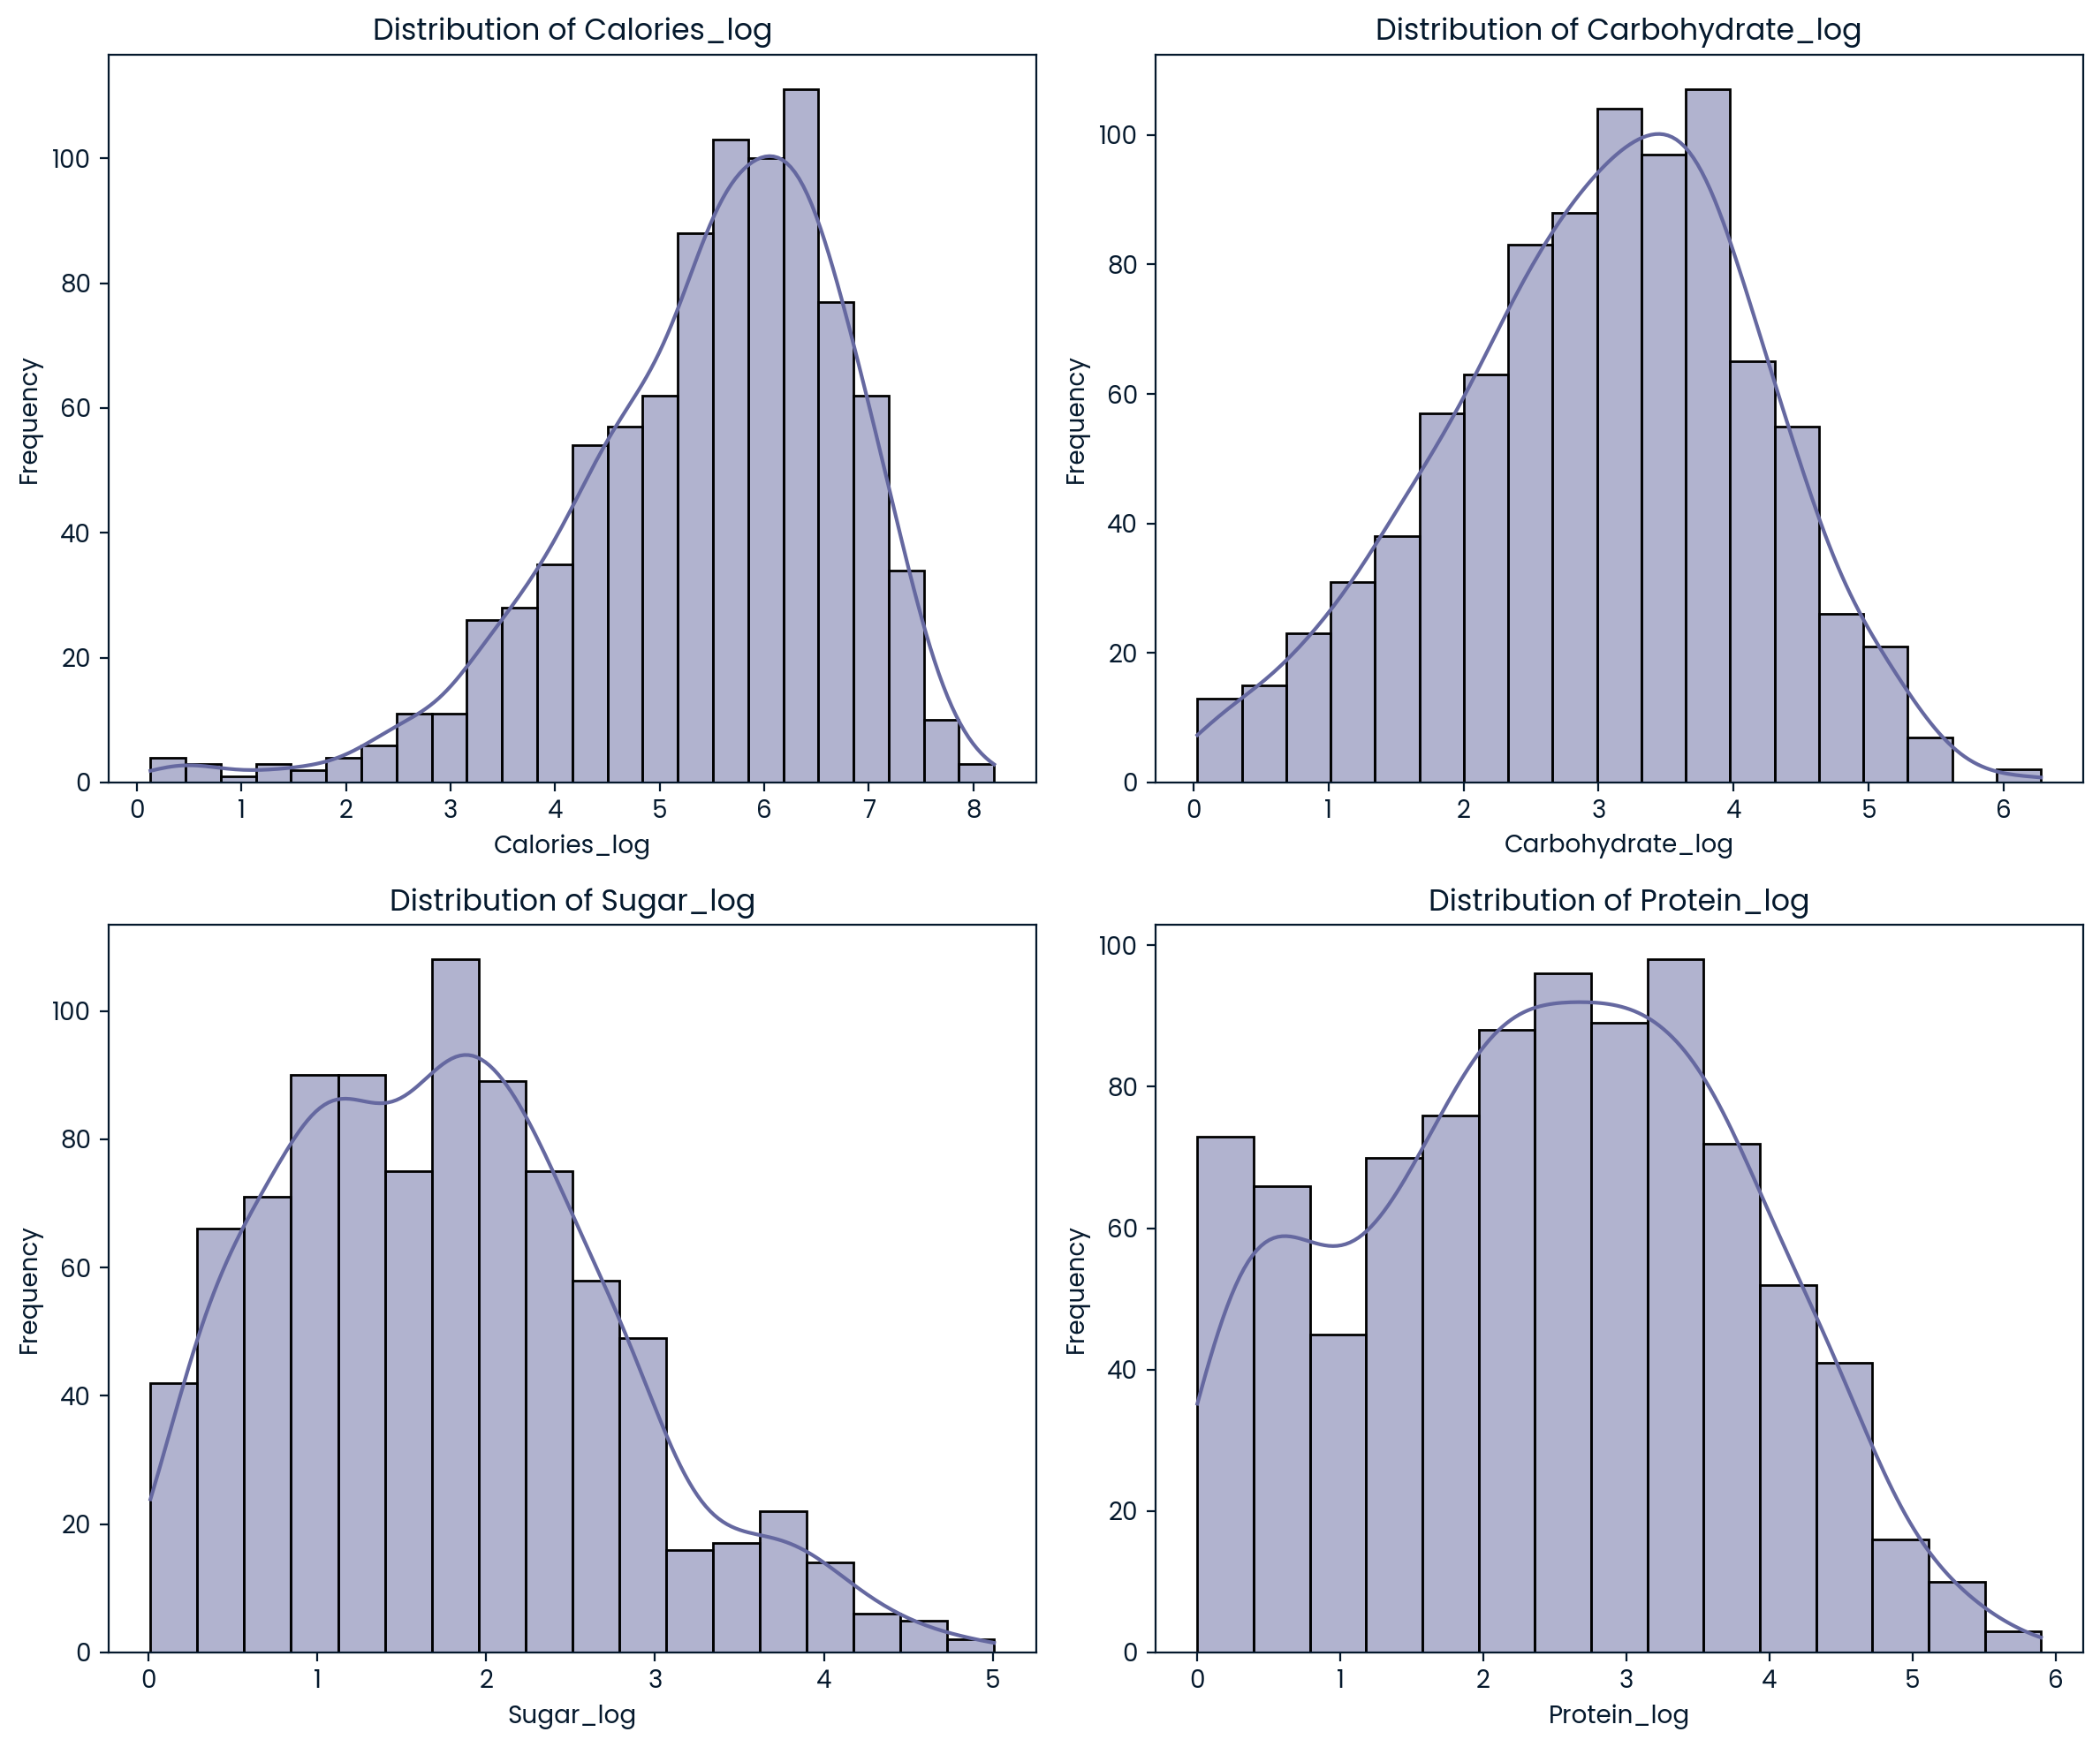

In [174]:
# Log transform numeric columns
for col in hist_cols:
    df[f'{col}_log'] = np.log(df[col] + 1)
    
log_cols = ['calories_log', 'carbohydrate_log', 'sugar_log', 'protein_log']

plt.figure(figsize=(12, 10))
for i, col in enumerate(log_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df[col], kde=True)
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

As evident below, the `serving size` of a recipe has little impact on whether the recipe generates high traffic or not. This means that users may not be particularly swayed by the `serving size` when deciding whether to view or engage with a recipe. Given this result, it is important to consider the relationship between other variables and `high_traffic`.

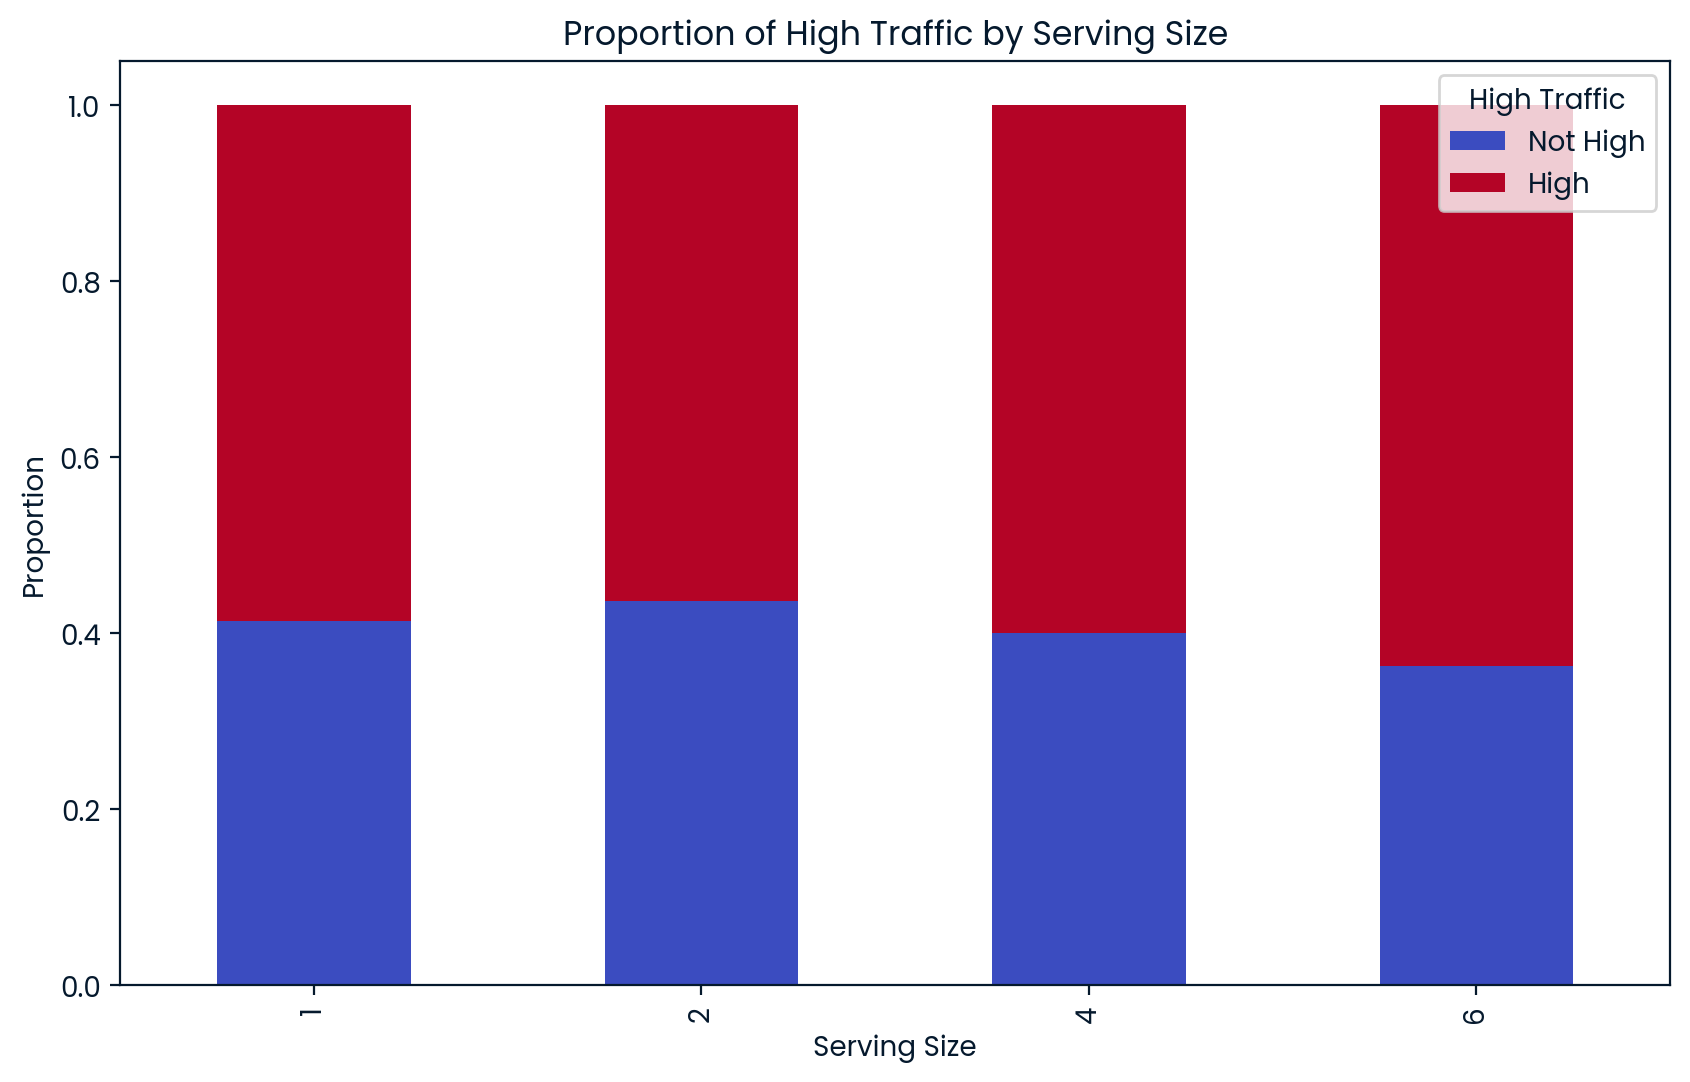

In [175]:
# Create a crosstab to count occurrences of high_traffic per servings
servings_high_traffic = pd.crosstab(df['servings'], df['high_traffic'], normalize='index')

# Plotting the stacked bar chart
servings_high_traffic.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))

plt.title('Proportion of High Traffic by Serving Size')
plt.xlabel('Serving Size')
plt.ylabel('Proportion')
plt.legend(title='High Traffic', labels=['Not High', 'High'])
plt.show()

As indicated by the stacked bar chart below, recipe categories `beverages`, `breakfast`, and `chicken` generate high traffic the least often, while `vegetable`, `potato`, and `pork` categories generate the most high traffic. Recipe category clearly has a high impact on whether or not a recipe generates high traffic, supported by the two extreme ends of this chart.

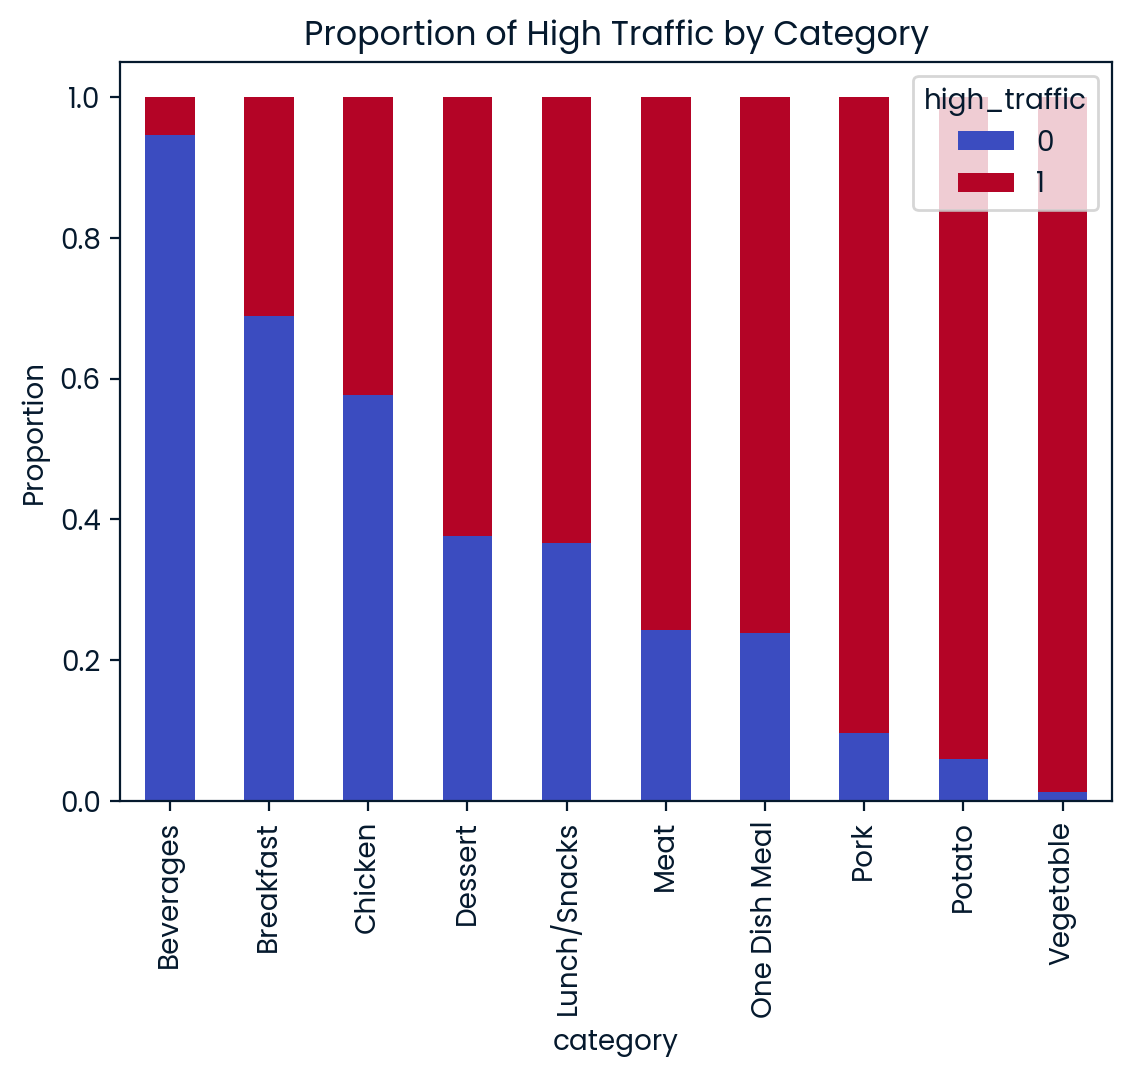

In [176]:
category_high_traffic = pd.crosstab(df['category'], df['high_traffic'], normalize='index')
category_high_traffic.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of High Traffic by Category')
plt.ylabel('Proportion')
plt.show()

# Model Fitting

As stated earlier, since this is a binary classification problem (identifying if a recipe will generate high traffic: `1` or not `0`), the first model I have decided to fit is a logistic regression model. I chose this model because the coefficients of the final logistic regression model will help identify the best variables to use in a comparative model I will choose after fitting the initial model.

I will split the data into training and validation samples, train the model on the training data, and evaluate its' performance on the validation data.

Additionally, I will need to encode the `category` column via one hot encoding in order to train models on the data and evaluate their accuracy.

In [177]:
# Encode category column
encoded_categories = pd.get_dummies(df['category'])
df_encoded = pd.concat([df, encoded_categories], axis=1)
df_encoded.drop(['category'], axis=1, inplace=True)

In [178]:
# Split data into X/y
X = df_encoded.drop(['high_traffic'], axis=1)
y = df_encoded['high_traffic']

# Split data into training/validation samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=557)

In [179]:
# Model fit and accuracy function
def fit_model(model, X_train, X_test, y_train, y_test):
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Train metrics
    acc_train = accuracy_score(y_train, pred_train)
    precision_train = precision_score(y_train, pred_train)
    recall_train = recall_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train)
    
    # Test metrics
    acc_test = accuracy_score(y_test, pred_test)
    precision_test = precision_score(y_test, pred_test)
    recall_test = recall_score(y_test, pred_test)
    f1_test = f1_score(y_test, pred_test)
    
    # Create metrics dict
    metrics = {}
    metrics['train'] = {'acc': acc_train, 'precision': precision_train, 'recall': recall_train, 'f1': f1_train}
    metrics['test'] = {'acc': acc_test, 'precision': precision_test, 'recall': recall_test, 'f1': f1_test}
    return metrics

def print_metrics(metrics):
    print(f"Accuracy: {metrics['acc']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1: {metrics['f1']}")

In [180]:
# Logistic Regression Model
log_reg = LogisticRegression()

log_reg_metrics = fit_model(log_reg, X_train, X_test, y_train, y_test)
print(log_reg_metrics)

{'train': {'acc': 0.7704918032786885, 'precision': 0.8029925187032418, 'recall': 0.8110831234256927, 'f1': 0.807017543859649}, 'test': {'acc': 0.7366071428571429, 'precision': 0.8264462809917356, 'recall': 0.7246376811594203, 'f1': 0.7722007722007722}}


After investigating the logistic regression model, I have decided to fit a random forest and decision tree classifier model as well. The logistic regression model meets the required 80% precision score (`0.813` for training data, `0.826` for test data) needed by the business. Additionally, there is a difference between training and test accuracy metrics, which can be explained by the limited data. Finally, there is no indication of over fitting but checking for that with additional models will be critical.

**Logistic Regression Training Data Metrics:**
- Accuracy: `0.7705`
- Precision: `0.803`
- Recall: `0.8111`
- F1: `0.807`

**Logistic Regression Test Data Metrics:**
- Accuracy: `0.7366`
- Precision: `0.8264`
- Recall: `0.7246`
- F1: `0.7722`

In [181]:
print("Logistic Regression Training Metrics:")
print_metrics(log_reg_metrics['train'])
print("\nLogistic Regression Test Metrics:")
print_metrics(log_reg_metrics['test'])

Logistic Regression Training Metrics:
Accuracy: 0.7704918032786885
Precision: 0.8029925187032418
Recall: 0.8110831234256927
F1: 0.807017543859649

Logistic Regression Test Metrics:
Accuracy: 0.7366071428571429
Precision: 0.8264462809917356
Recall: 0.7246376811594203
F1: 0.7722007722007722


In [182]:
# Random forest model
rf = RandomForestClassifier()

rf_metrics = fit_model(rf, X_train, X_test, y_train, y_test)
print(rf_metrics)

{'train': {'acc': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'test': {'acc': 0.75, 'precision': 0.8059701492537313, 'recall': 0.782608695652174, 'f1': 0.7941176470588236}}


In [183]:
# Decision tree model
dt = DecisionTreeClassifier()

dt_metrics = fit_model(dt, X_train, X_test, y_train, y_test)
print(dt_metrics)

{'train': {'acc': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'test': {'acc': 0.6741071428571429, 'precision': 0.76, 'recall': 0.6884057971014492, 'f1': 0.7224334600760457}}


After training and analyzing the accuracy metrics of both a random forest and decision tree model - both have indicated over-fitting of the data. This is demonstrated by training accuracy statistics of `1.0` for both models. This is most likely due to the low number of observations in the data set combined with the robust nature of these two model algorithms. There are numerous ways to address this overfitting (including training sample size and cross validation for example). However, due to the limited data available these techniques still may not yield the results I am looking for.

**Random Forest Training Data Metrics:**
- Accuracy: `1.0`
- Precision: `1.0`
- Recall: `1.0`
- F1: `1.0`

**Random Forest Test Data Metrics:**
- Accuracy: `0.75`
- Precision: `0.806`
- Recall: `0.7826`
- F1: `0.7941`



**Decision Tree Training Data Metrics:**
- Accuracy: `1.0`
- Precision: `1.0`
- Recall: `1.0`
- F1: `1.0`

**Decision Tree Test Data Metrics:**
- Accuracy: `0.6741`
- Precision: `0.76`
- Recall: `0.6884`
- F1: `0.7224`

In [184]:
print("Random Forest Training Metrics:")
print_metrics(rf_metrics['train'])
print("\nRandom Forest Test Metrics:")
print_metrics(rf_metrics['test'])

print("\n\n\nDecision Tree Training Metrics:")
print_metrics(dt_metrics['train'])
print("\nDecision Tree Test Metrics:")
print_metrics(dt_metrics['test'])

Random Forest Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Random Forest Test Metrics:
Accuracy: 0.75
Precision: 0.8059701492537313
Recall: 0.782608695652174
F1: 0.7941176470588236



Decision Tree Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Decision Tree Test Metrics:
Accuracy: 0.6741071428571429
Precision: 0.76
Recall: 0.6884057971014492
F1: 0.7224334600760457


# KPI & Business Requirements

As my KPI I chose F1 score, given that is a harmonic mean between precision (a curical measurement for meeting business requirements) and recall. The business requirements indicate a need for high precision (a model must be able to identify high-traffic recipes correctly 80% of the time), and minimizing the number of potential high-traffic recipes the model fails to identify (recall). Focusing individually one just one of these metrics could lead to false-positive/false-negative bias when analyzing model performance.

Using this KPI, the 3 models have F1 scores as follows:

- Logistic Regression Model: `0.7722`
- Random Forest Model: `0.7941`
- Decision Tree Model: `0.7244`

While the Random forest model does have the highest F1 score, as discussed earlier, the model was overfitted to the training data, and therefore will not be the model I choose. The Logistic Regression model has the second highest F1 score at `0.7722`. This KPI was chosen to compare models, not to establish if the business requirements were met. The F1 score of the Logistic Regression model does not meet the 80% reqirement established by the business, but the precision score (a better measure of if a given model is accurately predicting recipes that will generate high traffic) is above the 80% requirement (`0.8624`).

Therefore, after considering the KPI and other model accuracy metrics, I will reccommend the use of the logistic regression model by the business.

# Final Thoughts & Reccomendations

In conclusion, my efforts in developing and evaluating multiple models successfully met the project objectives. Among the models tested, the logistic regression model proved to be the most effective, demonstrating its suitability for predicting high-traffic recipes with an accuracy of 80%. From a business perspective, the more critical error is predicting a high-traffic recipe as low traffic rather than the reverse. Therefore, we prioritized model precision, as incorrectly classifying a high-traffic recipe as low traffic could lead to significant business losses. Additionally, I implemented the F1 score as a KPI to facilitate comparisons between the models. Through exploratory analysis, we identified certain recipe categories that consistently generate high or low traffic. Specifically, "Vegetable," "Potato," and "Pork" recipes tend to attract high traffic, making them strong candidates for featuring on the website. On the other hand, "Beverages" generally result in low traffic, suggesting they should not be prioritized for display.